# Tennis Match Predictor

Author: David Hidalgo Fàbregas  
Date: 31/01/2026

## Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## Load data

In [2]:
matches = pd.read_csv('../Dataset/atp_matches_till_2022.csv')

# Ensure chronological order
matches['tourney_date'] = pd.to_datetime(matches['tourney_date'], format='%Y%m%d', errors='coerce')
matches = matches.sort_values('tourney_date').reset_index(drop=True)

## 1. Elo System

The official ATP ranking sometimes takes time to reflect a player's current form, while a dynamic Elo rating adapts more quickly.

In [3]:
elo_general = {}
elo_surface = {
    'Hard': {},
    'Clay': {},
    'Grass': {},
    'Carpet': {} 
}

k_factor = 32  # How much does the score change per game?

def get_elo(player_id, surface):
    # First check surface-specific Elo, then general Elo, then default to 1500.
    if surface in elo_surface and player_id in elo_surface[surface]:
        return elo_surface[surface][player_id]
    return elo_general.get(player_id, 1500)

winner_elo_list = []
loser_elo_list = []

for idx, row in matches.iterrows():
    w_id = row['winner_id']
    l_id = row['loser_id']
    surface = row['surface']

    w_elo_surf = get_elo(w_id, surface)
    l_elo_surf = get_elo(l_id, surface)
    
    # We save the Elo rating BEFORE the match (this is what the model will use).
    winner_elo_list.append(w_elo_surf)
    loser_elo_list.append(l_elo_surf)
    
    # Compute expected probabilities
    expected_w = 1 / (1 + 10 ** ((l_elo_surf - w_elo_surf) / 400))
    expected_l = 1 / (1 + 10 ** ((w_elo_surf - l_elo_surf) / 400))
    
    # Update Elos
    if surface in elo_surface:
        elo_surface[surface][w_id] = w_elo_surf + k_factor * (1 - expected_w)
        elo_surface[surface][l_id] = l_elo_surf + k_factor * (0 - expected_l)

    # Update general Elo
    gen_w = elo_general.get(w_id, 1500)
    gen_l = elo_general.get(l_id, 1500)
    prob_w = 1 / (1 + 10 ** ((gen_l - gen_w) / 400))
    prob_l = 1 / (1 + 10 ** ((gen_w - gen_l) / 400))
    elo_general[w_id] = gen_w + k_factor * (1 - prob_w)
    elo_general[l_id] = gen_l + k_factor * (0 - prob_l)
    
# Add to dataframe
matches['w_elo_surf'] = winner_elo_list
matches['l_elo_surf'] = loser_elo_list
matches['w_elo_gen'] = matches['winner_id'].apply(lambda x: elo_general.get(x, 1500))
matches['l_elo_gen'] = matches['loser_id'].apply(lambda x: elo_general.get(x, 1500))

In [4]:
print(matches.columns.values)

['tourney_id' 'tourney_name' 'surface' 'draw_size' 'tourney_level'
 'tourney_date' 'match_num' 'winner_id' 'winner_seed' 'winner_entry'
 'winner_name' 'winner_hand' 'winner_ht' 'winner_ioc' 'winner_age'
 'loser_id' 'loser_seed' 'loser_entry' 'loser_name' 'loser_hand'
 'loser_ht' 'loser_ioc' 'loser_age' 'score' 'best_of' 'round' 'minutes'
 'w_ace' 'w_df' 'w_svpt' 'w_1stIn' 'w_1stWon' 'w_2ndWon' 'w_SvGms'
 'w_bpSaved' 'w_bpFaced' 'l_ace' 'l_df' 'l_svpt' 'l_1stIn' 'l_1stWon'
 'l_2ndWon' 'l_SvGms' 'l_bpSaved' 'l_bpFaced' 'winner_rank'
 'winner_rank_points' 'loser_rank' 'loser_rank_points' 'w_elo_surf'
 'l_elo_surf' 'w_elo_gen' 'l_elo_gen']


## 2. Feature Engineering and Selection
Only data known before the game can be used.  
Do not use statistics from the current game (such as w_ace or minutes from the same game), but historical averages can be used.
- Ranking difference: `Rank_A-Rank_B`. Logarithm might be useful because the difference between `#1` and `#5` is more significative than `#100` and `#105`.
- Elo difference: `Elo_A-Elo_B`.
- Surface performance: winning percentage of the player in this surface in the last year.
- Head-to-Head history: How many times A has won against B in the past.
- Exhaustion: How many matches did the player play in the last 2 weeks. How many minuts did the player play in the last match?
- Phisical Data: Heigh difference, dominant hand...

### 2.1 Transform cathegorical variables into numerical variables

Round map

In [5]:
# Round map
round_map = {
    'R128': 1,
    'R64': 2,
    'R32': 3,
    'R16': 4,
    'QF': 5,
    'SF': 6,
    'BR': 6.5, # Bronze Medal (Third-place play-off between SF and Final)
    'F': 7,
    'RR': 8,   # Round Robin (It is usually the ATP Finals, a very high level)
    'ER': 1    # Early Round (It is usually used in the Davis Cup or very low rounds, minimum value)
}

Tourney level map

In [6]:
# Tourney level map
level_map = {
    'G': 5,  # Grand Slam
    'F': 4,  # Tour Finals
    'M': 3,  # Masters 1000
    'A': 2,  # ATP 250/500
    'D': 2,  # Davis Cup (Level similar to average ATP in difficulty)
    'C': 1,  # Challengers
    'S': 1   # Satellites/Futures
}

Predominant-hand

In [7]:
def is_lefty(player):
    """
    Transforms cathegorical variable of predominant-hand into numerical variable.
    Returns 1 if left-handed (L), 0 if right-handed (R), NAN if unknown (U).
    """
    if player['hand'] == 'L':
        return 1 
    elif player['hand'] == 'R':
        return 0
    else:
        return np.nan

### 2.2 History of matches and matchups

In [8]:
WINDOW_SIZE = 10  # Last N matches for overall form (you can try 5 or 10)

# We define the metrics we are going to save for each match.
stats_cols = [
    'ace',
    'df',
    'svpt',
    '1stIn',
    '1stWon',
    '2ndWon',
    'SvGms',
    'bpSaved',
    'bpFaced'
]

In [9]:
def get_avg_stats(history_list):
    """
    Compute the average of the statistics stored in a list.
    """
    if not history_list:
        return {} # Returns empty if there is no history
    
    # We transpose the dictionary list to calculate averages by key.
    avgs = {}
    keys = history_list[0].keys()
    
    for k in keys:
        values = [match[k] for match in history_list if match[k] is not np.nan]
        if values:
            avgs[f"avg_{k}"] = np.mean(values)
        else:
            avgs[f"avg_{k}"] = 0
            
    # --- CALCULATION OF DERIVATIVE PERCENTAGES ---
    # It is best to average the resulting percentages.
    if avgs.get('avg_svpt', 0) > 0:
        # % 1st service
        avgs['pct_1stIn'] = avgs.get('avg_1stIn', 0) / avgs.get('avg_svpt')
        # % Points won on first serve (out of those played)
        avgs['pct_1stWon'] = avgs.get('avg_1stWon', 0) / avgs.get('avg_1stIn') if avgs.get('avg_1stIn', 0) > 0 else 0
        # % Points won on second serve
        avgs['pct_2ndWon'] = avgs.get('avg_2ndWon', 0) / (avgs.get('avg_svpt') - avgs.get('avg_1stIn')) if (avgs.get('avg_svpt') - avgs.get('avg_1stIn')) > 0 else 0
        
    # --- RECENT WIN RATE ---
    if not history_list:
        p1_win_pct = 0.5
    else:
        wins = sum(m.get('won', 0) for m in history_list)
        p1_win_pct = wins / len(history_list)
    avgs['recent_win_pct'] = p1_win_pct
    return avgs

In [10]:
def general_history(history_dict, player):
    """
    Gets the average statistics of a player from the recorded historical window.
    """
    player_id = player['id']
    player_history_list = history_dict.get(player_id, [])
    player_stats = get_avg_stats(player_history_list)

    return player_stats


In [11]:
def h2h_history(history_dict, player1, player2):
    """
    Gets the average statistics of the matchups between two players.
    """
    player1_id = player1['id']
    player2_id = player2['id']

    h2h_key = tuple(sorted([player1_id, player2_id]))
    matchup_history = history_dict.get(h2h_key, {})

    player1_h2h_list = matchup_history.get(player1_id, [])
    player2_h2h_list = matchup_history.get(player2_id, [])

    player1_h2h_stats = get_avg_stats(player1_h2h_list)
    player2_h2h_stats = get_avg_stats(player2_h2h_list)

    matches_num = len(player1_h2h_list)
    if matches_num > 0:
        p1_wins = sum(m.get('won', 0) for m in player1_h2h_list)
        p1_win_pct = p1_wins / matches_num
    else:
        p1_win_pct = 0.5 # Neutral value if they never played

    return player1_h2h_stats, player2_h2h_stats, matches_num, p1_win_pct

In [12]:
def update_general_history(history_dict, player, new_stats, max_len=None):
    """
    Adds statistics to the general history of a player.
    """
    player_id = player['id']
    if player_id not in history_dict:
        history_dict[player_id] = []

    history_dict[player_id].append(new_stats)
    if max_len is not None and len(history_dict[player_id])>max_len:
        history_dict[player_id].pop(0)

In [13]:
def update_h2h_history(history_dict, player1, player2, player1_new_stats, player2_new_stats):
    """
    Adds statistics to the H2H history of matchups between two players.
    """
    player1_id = player1['id']
    player2_id = player2['id']

    h2h_match = tuple(sorted([player1_id, player2_id]))
    if h2h_match not in history_dict:
        history_dict[h2h_match] = {
            player1_id: [],
            player2_id: []
        }
    if player1_id not in history_dict[h2h_match]: history_dict[h2h_match][player1_id] = []
    if player2_id not in history_dict[h2h_match]: history_dict[h2h_match][player2_id] = []

    history_dict[h2h_match][player1_id].append(player1_new_stats)
    history_dict[h2h_match][player2_id].append(player2_new_stats)

### 2.3 Fatigue

In [14]:
def get_days_rest(last_match_date, player, current_date):
    player_id = player['id']
    if player_id in last_match_date:
        delta = (current_date - last_match_date[player_id]).days
        # Data cleaning: if negative or > 60, we correct it.
        if delta < 0: return 30 
        if delta > 60: return 60 
        return delta
    return 30 # Neutral value for the first game (fresh)

### 2.4 Seed

In [15]:
def get_seed_value(p1):
    seed = p1['seed']
    if pd.isnull(seed):
        return 36
    return seed

### 2.5 Restructure DataFrame - Player A vs Player B

The data has columns named winner_name and loser_name.

The common mistake: If model is trained with these columns, it will quickly learn that te person in the "Winner" column always wins.

**Solution**: Transform each row into a neutral matchup, Player A vs Player B.

The target variable will be: Did player A win? 1 if yes, 0 if no.

It must be randomized who is Player A and who is Player B in each row so that your dataset has a 50/50 balance of wins and losses.

In [16]:
dataset = []
history_general = {}    # Recent history
history_h2h = {}        # Head-to-head history
last_match_date = {}    # To compute fatigue based on last match date
last_match_minutes = {} # To compute fatigue based on match duration

for idx, row in matches.iterrows():

    # --- RANDOMIZE WINNER/LOSER INTO P1/P2 ---
    winner = {'id': row['winner_id'],
              'elo_surf': row['w_elo_surf'],
              'elo_gen': row['w_elo_gen'],
              'atp_rank': row['winner_rank'],
              'atp_points': row['winner_rank_points'],
              'age': row['winner_age'],
              'hand': row['winner_hand'],
              'height': row['winner_ht'],
              'ioc': row['winner_ioc'],
              'seed': row['winner_seed']}
    
    loser = {'id': row['loser_id'],
              'elo_surf': row['l_elo_surf'],
              'elo_gen': row['l_elo_gen'],
              'atp_rank': row['loser_rank'],
              'atp_points': row['loser_rank_points'],
              'age': row['loser_age'],
              'hand': row['loser_hand'],
              'height': row['loser_ht'],
              'ioc': row['loser_ioc'],
              'seed': row['loser_seed']}
    
    if random.random() > 0.5:
        # Case: P1 wins
        p1 = winner
        p2 = loser
        target = 1
    else:
        # Case: P1 loses
        p1 = loser
        p2 = winner
        target = 0
        
    # --- FEATURE ENGINEERING ---
    # Predominant-hand
    p1_lefty = is_lefty(p1)
    p2_lefty = is_lefty(p2)
    # Same country
    is_same_country = 1 if (p1['ioc'] == p2['ioc']) else 0
    # Round of the match
    round_value = round_map.get(row['round'])
    # Tourney level
    tl_value = level_map.get(row['tourney_level'])
    # History
    p1_stats = general_history(history_general, p1)
    p2_stats = general_history(history_general, p2)
    p1_h2h_stats, p2_h2h_stats, matches_num, p1_h2h_win_pct = h2h_history(history_h2h, p1, p2)
    # Fatigue (not used directly but could be added)
    p1_last_mins = last_match_minutes.get(p1['id'], 0)
    p2_last_mins = last_match_minutes.get(p2['id'], 0)
    # Seed
    p1_seed = get_seed_value(p1)
    p2_seed = get_seed_value(p2)

    # --- SAVE FEATURES INTO DATASET ---
    dataset.append({
        'date': row['tourney_date'],

        # P1 vs P2
        'diff_elo_surf': p1['elo_surf'] - p2['elo_surf'],               # P1 better than P2?
        'diff_elo_gen': p1['elo_gen'] - p2['elo_gen'],                  # P1 better than P2?
        'diff_rank': np.log(p1['atp_rank']) - np.log(p2['atp_rank']),   # ATP ranking difference
        'diff_points': p1['atp_points'] - p2['atp_points'],             # ATP points difference
        'diff_age': p1['age'] - p2['age'],                              # P1 older?
        'diff_height': p1['height']-p2['height'],                       # P1 taller?
        'diff_last_minutes': p1_last_mins - p2_last_mins,               # P1 less tired from last match?
        'same_country': is_same_country,

        # Tournament
        'surface': row['surface'],  # Needs One-Hot Encoding later
        'tourney_level': tl_value,
        'best_of': row['best_of'],
        'draw_size': row['draw_size'],
        'round': round_value,
        'diff_seed': p1_seed - p2_seed,        

        # Stats P1
        'p1_is_lefty': p1_lefty,
        'p1_recent_win_pct': p1_stats.get('recent_win_pct'),
        'p1_ace': p1_stats.get('avg_ace'),
        'p1_df': p1_stats.get('avg_df'),
        'p1_1stWon': p1_stats.get('pct_1stWon'),
        'p1_bpSaved': p1_stats.get('avg_bpSaved'),
        'p1_pct_1sIn': p1_stats.get('pct_1stIn'),
        'p1_pct_1sWon': p1_stats.get('pct_1stWon'),
        'p1_pct_2ndWon': p1_stats.get('pct_2nWon'),

        # Stats P1
        'p2_is_lefty': p2_lefty,
        'p2_recent_win_pct': p2_stats.get('recent_win_pct'),
        'p2_ace': p2_stats.get('avg_ace'),
        'p2_df': p2_stats.get('avg_df'),
        'p2_1stWon': p2_stats.get('pct_1stWon'),
        'p2_bpSaved': p2_stats.get('avg_bpSaved'),
        'p2_pct_1sIn': p2_stats.get('pct_1stIn'),
        'p2_pct_1sWon': p2_stats.get('pct_1stWon'),
        'p2_pct_2ndWon': p2_stats.get('pct_2nWon'),

        # H2H History
        'h2h_matches': matches_num, # Number of times they play each other
        'h2h_p1_win_pct': p1_h2h_win_pct,
        
        'p1_h2h_ace': p1_h2h_stats.get('avg_ace'),
        'p1_h2h_df': p1_h2h_stats.get('avg_df'),
        'p1_h2h_1stWon': p1_h2h_stats.get('pct_1stWon'),
        'p1_h2h_bpSaved': p1_h2h_stats.get('avg_bpSaved'),
        'p1_h2h_pct_1sIn': p1_h2h_stats.get('pct_1stIn'),
        'p1_h2h_pct_1sWon': p1_h2h_stats.get('pct_1stWon'),
        'p1_h2h_pct_2ndWon': p1_h2h_stats.get('pct_2nWon'),

        'p2_h2h_ace': p2_h2h_stats.get('avg_ace'),
        'p2_h2h_df': p2_h2h_stats.get('avg_df'),
        'p2_h2h_1stWon': p2_h2h_stats.get('pct_1stWon'),
        'p2_h2h_bpSaved': p2_h2h_stats.get('avg_bpSaved'),
        'p2_h2h_pct_1sIn': p2_h2h_stats.get('pct_1stIn'),
        'p2_h2h_pct_1sWon': p2_h2h_stats.get('pct_1stWon'),
        'p2_h2h_pct_2ndWon': p2_h2h_stats.get('pct_2nWon'),

        # Target
        'target': target
    })

    # --- UPDATE HISTORY AFTER THE MATCH ---
    if row['winner_id'] == p1['id']:
        # P1 Won
        stats_p1_now = {k: row[f'w_{k}'] for k in stats_cols} # E.g.: row['w_ace']
        stats_p2_now = {k: row[f'l_{k}'] for k in stats_cols} # E.g.: row['l_ace']
        stats_p1_now['won'] = 1
        stats_p2_now['won'] = 0
    else:
        # P1 Lost
        stats_p1_now = {k: row[f'l_{k}'] for k in stats_cols}
        stats_p2_now = {k: row[f'w_{k}'] for k in stats_cols}
        stats_p1_now['won'] = 0
        stats_p2_now['won'] = 1
        
    # --- UPDATE HISOTRIES ---
    # General history
    update_general_history(history_general, p1, stats_p1_now, max_len=WINDOW_SIZE)
    update_general_history(history_general, p2, stats_p2_now, max_len=WINDOW_SIZE)
    # H2H history
    update_h2h_history(history_h2h, p1, p2, stats_p1_now, stats_p2_now)
    # Last match date and minutes
    match_minutes = row['minutes'] if not pd.isna(row['minutes']) else 0
    last_match_minutes[p1['id']] = match_minutes
    last_match_minutes[p2['id']] = match_minutes

# --- CONVERT INTO DATAFRAME ---
df_train = pd.DataFrame(dataset)
df_train["p1_is_lefty"] = df_train["p1_is_lefty"].astype('Int64')
df_train["p2_is_lefty"] = df_train["p2_is_lefty"].astype('Int64')

# One Hot Encoding for surface (Clay, Grass, Hard)
df_train = pd.get_dummies(df_train, columns=['surface'], drop_first=True)
df_train = df_train.sort_values('date').reset_index(drop=True)

In [17]:
df_train.head()

,date,diff_elo_surf,diff_elo_gen,diff_rank,diff_points,diff_age,diff_height,diff_last_minutes,same_country,tourney_level,...,p2_h2h_df,p2_h2h_1stWon,p2_h2h_bpSaved,p2_h2h_pct_1sIn,p2_h2h_pct_1sWon,p2_h2h_pct_2ndWon,target,surface_Clay,surface_Grass,surface_Hard
0,1968-01-08,0.0,-32.105128,NaN,NaN,NaN,NaN,0.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,1,False,False,True
1,1968-01-08,-16.0,60.715513,NaN,NaN,NaN,NaN,0.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,1,False,False,True
2,1968-01-08,0.0,117.438598,NaN,NaN,NaN,NaN,0.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,1,False,False,True
3,1968-01-08,16.0,-10.726593,NaN,NaN,NaN,NaN,0.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,0,False,False,True
4,1968-01-08,-16.0,35.283745,NaN,NaN,NaN,NaN,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,None,1,False,False,True


In [18]:
num_nulls = df_train.isna().sum()
print(num_nulls[num_nulls > 0])

diff_rank             47240
diff_points           84530
diff_age               5560
diff_height           34790
p1_is_lefty            4007
p1_recent_win_pct      3575
p1_ace               123013
p1_df                123013
p1_1stWon            123014
p1_bpSaved           123013
p1_pct_1sIn          123014
p1_pct_1sWon         123014
p1_pct_2ndWon        188161
p2_is_lefty            3954
p2_recent_win_pct      3614
p2_ace               122968
p2_df                122968
p2_1stWon            122971
p2_bpSaved           122968
p2_pct_1sIn          122971
p2_pct_1sWon         122971
p2_pct_2ndWon        188161
p1_h2h_ace           150299
p1_h2h_df            150299
p1_h2h_1stWon        150301
p1_h2h_bpSaved       150299
p1_h2h_pct_1sIn      150301
p1_h2h_pct_1sWon     150301
p1_h2h_pct_2ndWon    188161
p2_h2h_ace           150299
p2_h2h_df            150299
p2_h2h_1stWon        150302
p2_h2h_bpSaved       150299
p2_h2h_pct_1sIn      150302
p2_h2h_pct_1sWon     150302
p2_h2h_pct_2ndWon   

In [19]:
print(num_nulls[num_nulls == 0])

date                 0
diff_elo_surf        0
diff_elo_gen         0
diff_last_minutes    0
same_country         0
tourney_level        0
best_of              0
draw_size            0
round                0
diff_seed            0
h2h_matches          0
h2h_p1_win_pct       0
target               0
surface_Clay         0
surface_Grass        0
surface_Hard         0
dtype: int64


## 3. Training and Validation

Since this is time-series data, DO NOT use random `train_test_split`. It must be splitted by time to simulate reality.

**Training**: Matches from 2000 to 2021.  
**Test**: Matches from 2022.

If it is mixed randomly, the model could learn from the "future" (e.g., use a match from 2022 to predict one from 2021), which will give a false accuracy.

In [20]:
cutting_date = pd.to_datetime('01122021', format='%d%m%Y')
X_train = df_train[df_train['date'] < cutting_date].drop(columns=['target', 'date'])
y_train = df_train[df_train['date'] < cutting_date]['target']
X_test = df_train[df_train['date'] >= cutting_date].drop(columns=['target', 'date'])
y_test = df_train[df_train['date'] >= cutting_date]['target']
print(f"Training matches (History): {len(X_train)}")
print(f"Testing matches (2022): {len(X_test)}")

Training matches (History): 185234
Testing matches (2022): 2927


By forcing `min_samples_leaf`, the model is prevented from creating rules for “one-off matches” and is forced to look for general patterns.

In [21]:
rf_model = RandomForestClassifier(
    n_estimators=300,       # Number of trees in the forest
    max_depth=20,           # Maximum depth of the tree to avoid overfitting
    min_samples_leaf=50,    # Minimum samples per leaf to reduce overfitting
    n_jobs=-1,              # Use all the CPU cores
    random_state=42         # Seed for reproducibility
)

print("Training model...")
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (2022 matches): {acc:.2f}")

Training model...
Test Accuracy (2022 matches): 0.69


### 3.2 Model performance and analysis

In [22]:
# Analysis dataframe
analysis = X_test.copy()
analysis['target'] = y_test
analysis['prediction'] = y_pred
analysis['correct'] = analysis['target'] == analysis['prediction']

# Accuracy by Tournament Level (Grand Slam vs. Rest)
print("--- Accuracy by Tourney Level (2022) ---")
level_acc = analysis.groupby('tourney_level')['correct'].mean()
inv_level_map = {v: k for k, v in level_map.items()}
level_acc.index = level_acc.index.map(inv_level_map)
print(level_acc)

# Accuracy per Round (Is it easier to predict R128 than Finals?)
print("\n--- Accuracy by Round ---")
round_acc = analysis.groupby('round')['correct'].mean()
inv_round_map = {v: k for k, v in round_map.items()}
round_acc.index = round_acc.index.map(inv_round_map)
print(round_acc)

--- Accuracy by Tourney Level (2022) ---
tourney_level
D    0.676221
M    0.667308
F    0.466667
G    0.777559
Name: correct, dtype: float64

--- Accuracy by Round ---
round
ER     0.746875
R64    0.734375
R32    0.654185
R16    0.682836
QF     0.656716
SF     0.640845
F      0.605634
RR     0.778523
Name: correct, dtype: float64



--- Top 10 Most Important Variables ---
              Feature  Importance
0       diff_elo_surf    0.267824
1        diff_elo_gen    0.183668
2           diff_rank    0.136604
12          diff_seed    0.086757
3         diff_points    0.057086
14  p1_recent_win_pct    0.038674
23  p2_recent_win_pct    0.034713
4            diff_age    0.023062
32     h2h_p1_win_pct    0.016896
5         diff_height    0.014583


C:\Users\hidal\AppData\Local\Temp\ipykernel_19620\1520919859.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


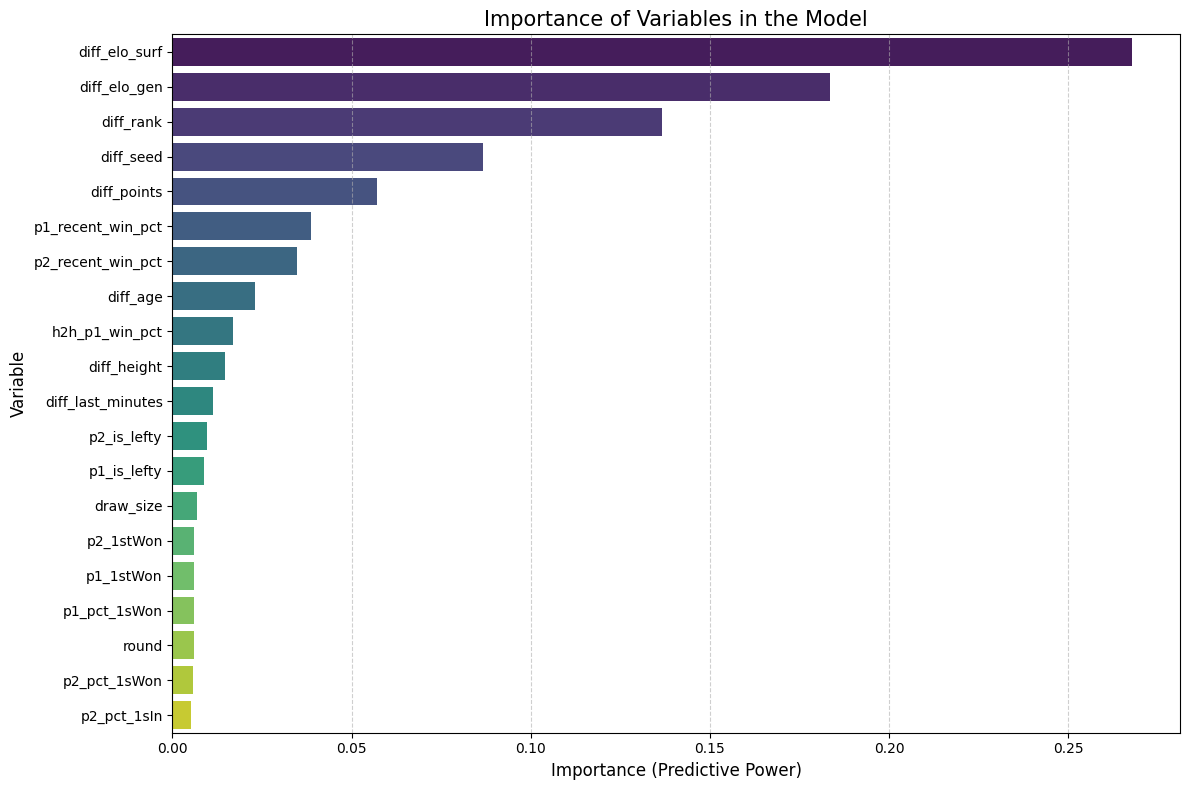

In [23]:
# Extract the importance of the variables
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Mostrar la tabla de las Top 10 (para ver el dato exacto)
print("\n--- Top 10 Most Important Variables ---")
print(feature_importance_df.head(10))

# 4. Generate graph
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(20), # Show the top 20 to make it readable.
    palette='viridis'
)

plt.title('Importance of Variables in the Model', fontsize=15)
plt.xlabel('Importance (Predictive Power)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [24]:
# Define a cutoff threshold (variables that contribute less than 0.5% are removed)
THRESHOLD = 0.005  # 0.5%

# Identify which variables survive
features_to_keep = feature_importance_df[feature_importance_df['Importance'] > THRESHOLD]['Feature'].tolist()
features_to_drop = feature_importance_df[feature_importance_df['Importance'] <= THRESHOLD]['Feature'].tolist()

print(f"Original Variables: {len(feature_names)}")
print(f"Selected variables: {len(features_to_keep)}")
print(f"Deleting {len(features_to_drop)} variables...")

# Create a new clean dataset
X_opt_train = X_train[features_to_keep].copy()
X_opt_test = X_test[features_to_keep].copy()

# Retrain and validate to see if there is improvement.
rf_model_opt = RandomForestClassifier(
    n_estimators=300,       # Number of trees in the forest
    max_depth=20,           # Maximum depth of the tree to avoid overfitting
    min_samples_leaf=50,    # Minimum samples per leaf to reduce overfitting
    n_jobs=-1,              # Use all the CPU cores
    random_state=42         # Seed for reproducibility
)

print("Training optimized model...")
rf_model_opt.fit(X_opt_train, y_train)
y_pred = rf_model_opt.predict(X_opt_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (2022 matches): {acc:.2f}")

Original Variables: 50
Selected variables: 21
Deleting 29 variables...
Training optimized model...
Test Accuracy (2022 matches): 0.70


In [25]:
features_to_keep

['diff_elo_surf',
 'diff_elo_gen',
 'diff_rank',
 'diff_seed',
 'diff_points',
 'p1_recent_win_pct',
 'p2_recent_win_pct',
 'diff_age',
 'h2h_p1_win_pct',
 'diff_height',
 'diff_last_minutes',
 'p2_is_lefty',
 'p1_is_lefty',
 'draw_size',
 'p2_1stWon',
 'p1_1stWon',
 'p1_pct_1sWon',
 'round',
 'p2_pct_1sWon',
 'p2_pct_1sIn',
 'p1_pct_1sIn']

### 3.1 Accumulative Season Validation

In [26]:
# Season starting in december
# Logic: Year + 1 if the month is >= 12 (December)
df_seasoned = df_train.copy()
df_seasoned['season_id'] = df_seasoned['date'].dt.year + (df_seasoned['date'].dt.month >= 12).astype(int)
print("Seasons identified:", df_seasoned['season_id'].unique())

def season_splitter(df, season_col):
    """
    Generator that returns indices (train, test) based on complete seasons.
    Training: Expansive (accumulates past seasons).
    Test: The immediately following season.
    """
    seasons = sorted(df[season_col].unique())
    if len(seasons) < 2:
        raise ValueError("Need at least 2 complete seasons in df_train to validate.")
    
    for i in range(1, len(seasons)):
        past_seasons = seasons[:i]
        current_season = seasons[i]
        
        train_idx = df[df[season_col].isin(past_seasons)].index.values
        test_idx = df[df[season_col] == current_season].index.values
        yield (train_idx, test_idx)

cols_exclude = ['target', 'date', 'season_id']
X = df_seasoned.copy().drop(columns=cols_exclude)
y = df_seasoned['target'].copy()

rf_model_acc = RandomForestClassifier(
    n_estimators=200,   # Number of trees in the forest
    max_depth=20,       # Maximum depth of the tree to avoid overfitting
    n_jobs=-1,          # Use all the CPU cores
    random_state=42     # Seed for reproducibility
)
cv_splits = season_splitter(df_seasoned, 'season_id')
scores = cross_val_score(rf_model_acc, X, y, cv=cv_splits, scoring='accuracy')

# Results
print("\n--- Results ---")
for i, score in enumerate(scores):
    print(f"Split {i+1} (Validate in season {sorted(df_seasoned['season_id'].unique())[i+1]}): {score:.2%}")
print(f"\nMean Accuracy: {scores.mean():.2%}")

Seasons identified: [1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981
 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]

--- Results ---
Split 1 (Validate in season 1969): 74.87%
Split 2 (Validate in season 1970): 75.84%
Split 3 (Validate in season 1971): 73.56%
Split 4 (Validate in season 1972): 72.79%
Split 5 (Validate in season 1973): 70.77%
Split 6 (Validate in season 1974): 73.12%
Split 7 (Validate in season 1975): 72.90%
Split 8 (Validate in season 1976): 73.25%
Split 9 (Validate in season 1977): 71.67%
Split 10 (Validate in season 1978): 71.04%
Split 11 (Validate in season 1979): 72.16%
Split 12 (Validate in season 1980): 71.94%
Split 13 (Validate in season 1981): 70.12%
Split 14 (Validate in season 1982): 68.87%
Split 15 (Validate in season 1983): 67.79%
Split 16 (Validate in season 1984): 67.38%
Spli

In [27]:
scores*100

array([74.86697966, 75.83688375, 73.56225572, 72.7914197 , 70.77441077,
       73.11594203, 72.9003093 , 73.24695122, 71.67209827, 71.04237068,
       72.15725305, 71.93940899, 70.12226184, 68.8672168 , 67.78819636,
       67.37984496, 66.70602125, 67.02317291, 68.52791878, 68.46318036,
       67.65280491, 66.51226158, 64.77059297, 65.47901821, 65.28670609,
       65.6678517 , 66.05263158, 66.80783483, 65.58548653, 64.92890995,
       64.33713257, 65.52234389, 64.74320242, 66.19981326, 65.72405221,
       65.19488429, 67.58578431, 68.16651362, 68.14768461, 68.71597823,
       69.45796819, 70.0330033 , 68.46816976, 70.55112882, 68.64809783,
       69.14856946, 69.96262317, 69.12614757, 67.12469942, 66.1373835 ,
       64.86101212, 66.62106703, 64.781491  , 65.86949095])

## 4. Predict

In [28]:
def predict_future_match(tourney, p1, p2):
    # --- FEATURE ENGINEERING ---
    # Predominant-hand
    p1_lefty = is_lefty(p1)
    p2_lefty = is_lefty(p2)
    # Same country
    is_same_country = 1 if (p1['ioc'] == p2['ioc']) else 0
    # Round of the match (we can set it to a neutral value, e.g., R32)
    round_value = round_map.get(tourney['round']) # Default to R32 if unknown
    # Tourney level
    tl_value = level_map.get(tourney['tourney_level'])
    # History
    p1_stats = general_history(history_general, p1)
    p2_stats = general_history(history_general, p2)
    p1_h2h_stats, p2_h2h_stats, matches_num, p1_h2h_win_pct = h2h_history(history_h2h, p1, p2)
    # Fatigue
    p1_last_mins = last_match_minutes.get(p1['id'], 0)
    p2_last_mins = last_match_minutes.get(p2['id'], 0)
    # Seed
    p1_seed = get_seed_value(p1)
    p2_seed = get_seed_value(p2)

    # Surface One-Hot Encoding (we need to do it manually here)
    surface_hard = 1 if tourney['surface'] == 'Hard' else 0
    surface_clay = 1 if tourney['surface'] == 'Clay' else 0
    surface_grass = 1 if tourney['surface'] == 'Grass' else 0

    # --- CREATE THE FEATURE VECTOR ---
    features = {
        # P1 vs P2
        'diff_elo_surf': p1['elo_surf'] - p2['elo_surf'],
        'diff_elo_gen': p1['elo_gen'] - p2['elo_gen'],
        'diff_rank': np.log(p1['atp_rank']) - np.log(p2['atp_rank']),
        'diff_points': p1['atp_points'] - p2['atp_points'],
        'diff_age': p1['age'] - p2['age'],
        'diff_height': p1['height']-p2['height'],
        'diff_last_minutes': p1_last_mins - p2_last_mins,
        'same_country': is_same_country,

        # Tournament
        'surface': tourney['surface'],  # Needs One-Hot Encoding later
        'tourney_level': tl_value,
        'best_of': tourney['best_of'],
        'draw_size': tourney['draw_size'],
        'round': round_value,
        'diff_seed': p1_seed - p2_seed,
        'surface_Clay': surface_clay,
        'surface_Grass': surface_grass,
        'surface_Hard': surface_hard,

        # Stats P1
        'p1_is_lefty': p1_lefty,
        'p1_recent_win_pct': p1_stats.get('recent_win_pct'),
        'p1_ace': p1_stats.get('avg_ace'),
        'p1_df': p1_stats.get('avg_df'),
        'p1_1stWon': p1_stats.get('pct_1stWon'),
        'p1_bpSaved': p1_stats.get('avg_bpSaved'),
        'p1_pct_1sIn': p1_stats.get('pct_1stIn'),
        'p1_pct_1sWon': p1_stats.get('pct_1stWon'),
        'p1_pct_2ndWon': p1_stats.get('pct_2nWon'),

        # Stats P2
        'p2_is_lefty': p2_lefty,
        'p2_recent_win_pct': p2_stats.get('recent_win_pct'),
        'p2_ace': p2_stats.get('avg_ace'),
        'p2_df': p2_stats.get('avg_df'),
        'p2_1stWon': p2_stats.get('pct_1stWon'),
        'p2_bpSaved': p2_stats.get('avg_bpSaved'),
        'p2_pct_1sIn': p2_stats.get('pct_1stIn'),
        'p2_pct_1sWon': p2_stats.get('pct_1stWon'),
        'p2_pct_2ndWon': p2_stats.get('pct_2nWon'),

        # H2H History
        'h2h_matches': matches_num,
        'h2h_p1_win_pct': p1_h2h_win_pct,
        'p1_h2h_ace': p1_h2h_stats.get('avg_ace'),
        'p1_h2h_df': p1_h2h_stats.get('avg_df'),
        'p1_h2h_1stWon': p1_h2h_stats.get('pct_1stWon'),
        'p1_h2h_bpSaved': p1_h2h_stats.get('avg_bpSaved'),
        'p1_h2h_pct_1sIn': p1_h2h_stats.get('pct_1stIn'),
        'p1_h2h_pct_1sWon': p1_h2h_stats.get('pct_1stWon'),
        'p1_h2h_pct_2ndWon': p1_h2h_stats.get('pct_2nWon'),
        'p2_h2h_ace': p2_h2h_stats.get('avg_ace'),
        'p2_h2h_df': p2_h2h_stats.get('avg_df'),
        'p2_h2h_1stWon': p2_h2h_stats.get('pct_1stWon'),
        'p2_h2h_bpSaved': p2_h2h_stats.get('avg_bpSaved'),
        'p2_h2h_pct_1sIn': p2_h2h_stats.get('pct_1stIn'),
        'p2_h2h_pct_1sWon': p2_h2h_stats.get('pct_1stWon'),
        'p2_h2h_pct_2ndWon': p2_h2h_stats.get('pct_2nWon')
    }

    return features

In [79]:
def get_player_info(player_id, date=datetime.now().strftime('%Y%m%d')):
    date=pd.to_datetime(date, format='%Y%m%d', errors='coerce')

    players = pd.read_csv('../Dataset/atp_players_till_2022.csv')
    players['dob'] = pd.to_datetime(players['dob'], format='%Y%m%d', errors='coerce')
    player_row = players[players['player_id'] == player_id]
    if player_row.empty:
        raise ValueError(f"Player ID {player_id} not found in players dataset.")
    player_dict = player_row.iloc[0].to_dict()

    atp_ranking = pd.read_csv('../Dataset/atp_rankings_till_2022.csv')
    atp_ranking['ranking_date'] = pd.to_datetime(atp_ranking['ranking_date'], format='%Y%m%d', errors='coerce')
    player_ranks = atp_ranking[atp_ranking['player'] == player_id].copy()
    past_ranks = player_ranks[player_ranks['ranking_date'] <= date]
    if past_ranks.empty:
        raise ValueError(f"No ATP ranking found for player ID {player_id} before date {date}.")
    latest_rank = past_ranks.sort_values('ranking_date', ascending=False).iloc[0]

    if player_row.empty:
        raise ValueError(f"Player ID {player_id} not found in players dataset.")
    
    # Age
    dob = player_dict['dob']
    age = date.year - dob.year - ((date.month, date.day) < (dob.month, dob.day))

    player_info = {
        'id': player_id,
        'elo_surf': elo_surface.get(player_id, 1500),
        'elo_gen': elo_general.get(player_id, 1500),
        'atp_rank': latest_rank['rank'],
        'atp_points': latest_rank['points'],
        'age': age,
        'hand': is_lefty(player_dict),
        'height': player_dict['height'],
        'ioc': player_dict['ioc']
    }
    return player_info

In [82]:
def get_real_probabilities(odd_p1, odd_p2):
    # 1. Implicit probabilities: 1 / odds (with margin)
    implied_p1 = (1 / odd_p1)
    implied_p2 = (1 / odd_p2)
    
    # 2. Add both implied probabilities to get the total (which is > 1 due to the margin)
    total_implied = implied_p1 + implied_p2
    
    # 3. Normalize to get real probabilities
    real_p1 = implied_p1 / total_implied
    real_p2 = implied_p2 / total_implied
    
    return real_p1 * 100, real_p2 * 100

### 4.1 Player ID Searcher

In [92]:
first_name = "Nick"
last_name = "Kyrgios"

players = pd.read_csv('../Dataset/atp_players_till_2022.csv')
p1 = players[players['name_last']==last_name]
p1 = p1[p1['name_first']==first_name]
p1

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
6386,106401,Nick,Kyrgios,R,19950427.0,AUS,193.0,Q3720084


### 4.2 Match prediction

In [96]:
p1 = get_player_info(106401) # Nick Kyrgios
p2 = get_player_info(104925) # Novak Djokovic

tourney = {
    'surface': 'Grass',
    'tourney_level': 'G', # Masters 1000
    'draw_size': 128,
    'round': 'F',
    'best_of': 5
}
p1["seed"] = 36
p2["seed"] = 1

features = predict_future_match(tourney, p1, p2)
features_df = pd.DataFrame([features])
features_df = features_df[X_train.columns]  # Ensure same order of columns
pred_prob = rf_model.predict_proba(features_df)[0][1]  # Probability of P1 winning
print(f"Predicted probability of P1 winning: {pred_prob:.1%}")
print(f"Predicted probability of P2 winning: {(1-pred_prob):.1%}")

p1_prob, p2_prob = get_real_probabilities(3.75, 1.28)
print(f"Player 1 Betting House Probability: {p1_prob:.1f}%") # Dará aprox 59.0%
print(f"Player 2 Betting House Probability: {p2_prob:.1f}%") # Dará aprox 41.0%

Predicted probability of P1 winning: 29.9%
Predicted probability of P2 winning: 70.1%
Player 1 Betting House Probability: 25.4%
Player 2 Betting House Probability: 74.6%
